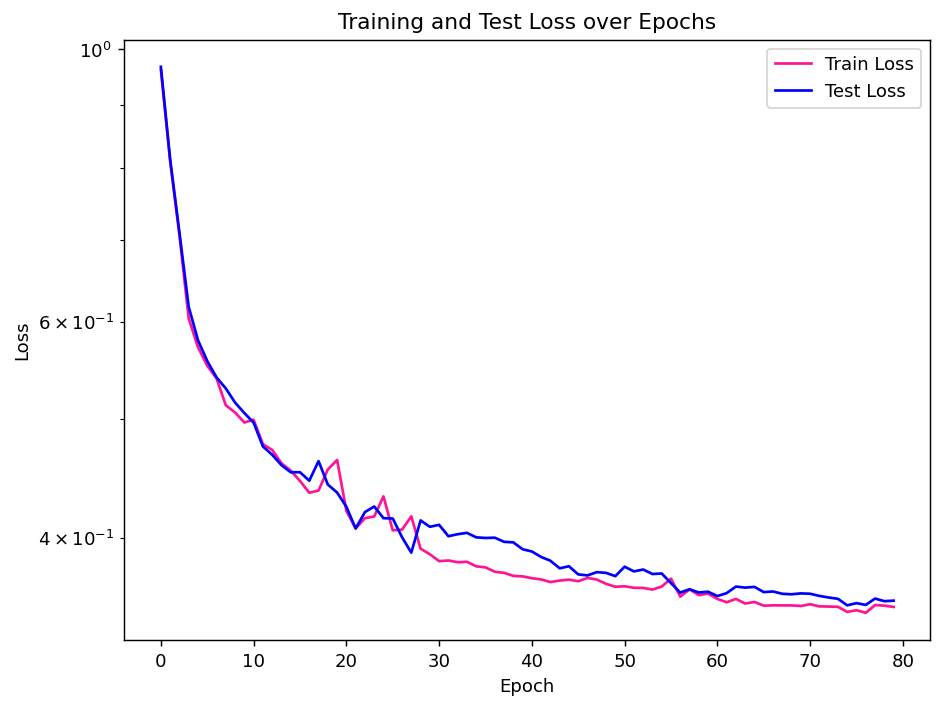

In [2]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the data
with open("train_history4.pkl", "rb") as f:
    history_train = pickle.load(f)

with open("test_history4.pkl", "rb") as f:
    history_test = pickle.load(f)

with open("output4.pkl", "rb") as f:
    output = pickle.load(f)

with open("cost4.pkl", "rb") as f:
    cost = pickle.load(f)

with open("per_point_losses_test4.pkl", "rb") as f:
    per_point_losses = pickle.load(f)

with open("average_loss_per_model4.pkl", "rb") as f:
    average_loss_per_model = pickle.load(f)


# Plot
fig = plt.figure(figsize=(8, 6), dpi=130)
plt.plot(history_train, label="Train Loss", color="deeppink")
plt.plot(history_test, label="Test Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend()
plt.title("Training and Test Loss over Epochs")
#plt.grid(True)
plt.savefig("traintestloss.jpg", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

In [3]:
grid = pd.read_pickle("outputs_in_instab_strip.pkl")

# then we have to first create the X and y matrices.

l_values = [0, 1, 2] 
l_columns = {l: [col for col in grid.columns if col.endswith(f"_l_{l}")] for l in l_values}

X_frequencies = np.hstack([grid[l_columns[l]].values for l in l_values])  
delta_nu_values = grid["delta_nu"].values[:, np.newaxis] 
mod_frequencies = X_frequencies % delta_nu_values 

X = np.stack((X_frequencies, mod_frequencies), axis=-1)
y = np.hstack([np.full_like(grid[l_columns[l]].values, l) for l in l_values])  

print(f"X-matrix shape: {X.shape}")
print(f"y-matrix shape: {y.shape}") 

from sklearn.model_selection import train_test_split
import torch

# Convert data to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)  # Assuming y contains class labels

# Split the data (80% train, 10% val, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print shape
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

size = X_train.shape[0]
inpt = X_train[:size]
print(inpt.shape)

X-matrix shape: (153314, 30, 2)
y-matrix shape: (153314, 30)
Train: torch.Size([122651, 30, 2]), Validation: torch.Size([15331, 30, 2]), Test: torch.Size([15332, 30, 2])
torch.Size([122651, 30, 2])


## Network performance on Echelle diagram

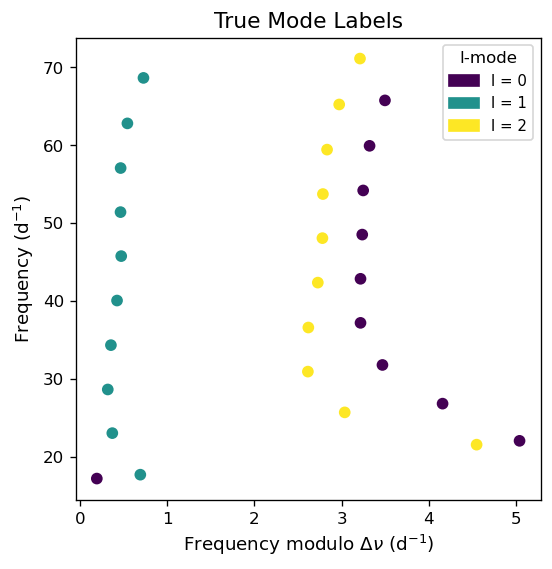

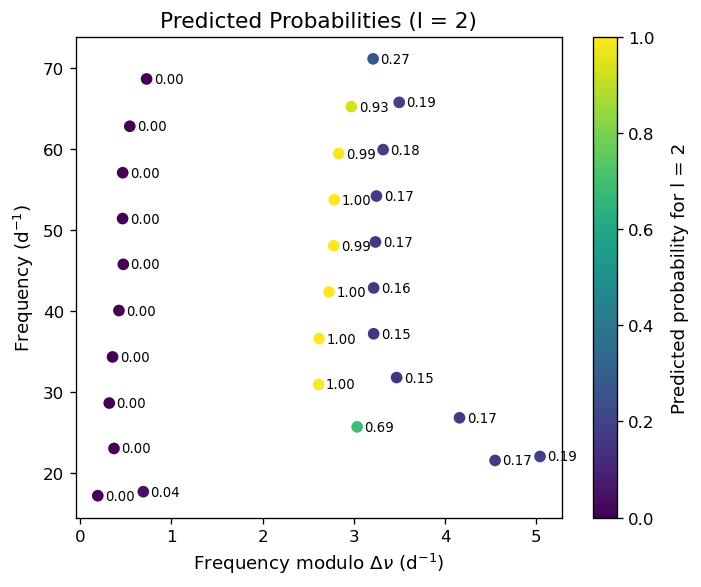

Sample Probabilities for class l = 2:
[0.1745 0.6865 0.9995 0.9995 0.9975 0.9949 0.9951 0.9909 0.9325 0.2697]


In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Setup
i_data = 50
l = 2  # Which mode (l=0,1,2) to plot probability for

# Extract data
freqs = inpt.detach().numpy()[i_data, :, 1]
powers = inpt.detach().numpy()[i_data, :, 0]
true_labels = y_train.detach().numpy()[i_data]
probs = output.exp().detach().numpy()[i_data, :, l]

# === First figure: True labels ===
fig1 = plt.figure(figsize=(5, 5), dpi=120)
sc1 = plt.scatter(freqs, powers, c=true_labels, cmap='viridis', vmin=0, vmax=2)

legend_elements = [
    mpatches.Patch(color=plt.cm.viridis(0.0), label='l = 0'),
    mpatches.Patch(color=plt.cm.viridis(0.5), label='l = 1'),
    mpatches.Patch(color=plt.cm.viridis(1.0), label='l = 2'),
]
plt.legend(handles=legend_elements, title="l-mode", loc="upper right", fontsize=9)
plt.title("True Mode Labels", fontsize=13)
plt.xlabel(r"Frequency modulo $\Delta \nu$ (d$^{-1}$)", fontsize=11)
plt.ylabel(r"Frequency (d$^{-1}$)", fontsize=11)
#plt.colorbar(sc1, label="True l-mode")
#plt.savefig("modetruelabels.jpg", bbox_inches="tight", pad_inches=0.3, transparent=True)

# === Second figure: Predicted probabilities for l ===
fig2 = plt.figure(figsize=(6, 5), dpi=120)
sc2 = plt.scatter(freqs, powers, c=probs, cmap='viridis', vmin=0.0, vmax=1.0)

# Add text labels slightly to the right of each point
for x, y, p in zip(freqs, powers, probs):
    plt.text(x + 0.08, y, f"{p:.2f}", fontsize=8, color="black", ha='left', va='center')

cbar = plt.colorbar(sc2)
cbar.set_label(f"Predicted probability for l = {l}", fontsize=11, labelpad=10)
cbar.ax.tick_params(labelsize=10)
plt.title(f"Predicted Probabilities (l = {l})", fontsize=13)
plt.xlabel(r"Frequency modulo $\Delta \nu$ (d$^{-1}$)", fontsize=11)
plt.ylabel(r"Frequency (d$^{-1}$)", fontsize=11)
plt.tight_layout()
#plt.savefig("modeidentification2.jpg", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

# === Print 10 sample probabilities ===
np.set_printoptions(precision=4, suppress=True)

if l == 0:
    l_values = output.exp().detach().numpy()[i_data, :10, 0]  # First 10 for l=0
elif l == 1:
    l_values = output.exp().detach().numpy()[i_data, 10:20, 1]  # Middle 10 for l=1
elif l == 2:
    l_values = output.exp().detach().numpy()[i_data, -10:, 2]  # Last 10 for l=2

print(f"Sample Probabilities for class l = {l}:")
print(l_values)

## Histogram

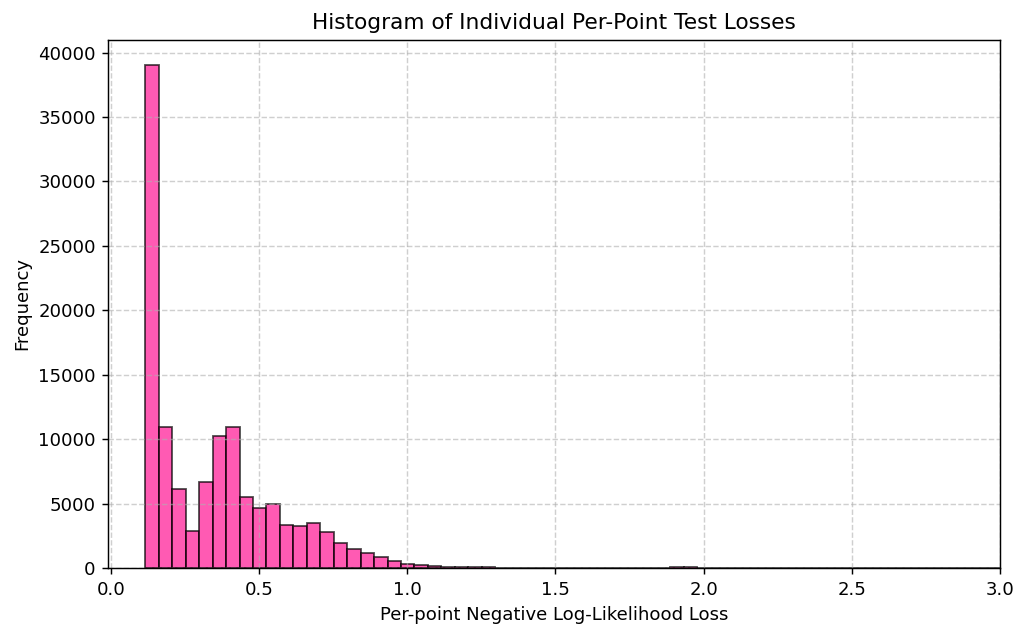

3679530
122651


In [5]:
import pickle
import matplotlib.pyplot as plt


# Plot histogram
plt.figure(figsize=(8, 5), dpi=130)
plt.hist(average_loss_per_model, bins=100, color='deeppink', edgecolor='black', alpha = 0.7)
plt.xlim(-0.01,3)
plt.xlabel("Per-point Negative Log-Likelihood Loss")
plt.ylabel("Frequency")
plt.title("Histogram of Individual Per-Point Test Losses")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("histogramperpointloss.jpg", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

print(per_point_losses.size)
print(average_loss_per_model.size)

## 10 randomly picked Echelle diagrams

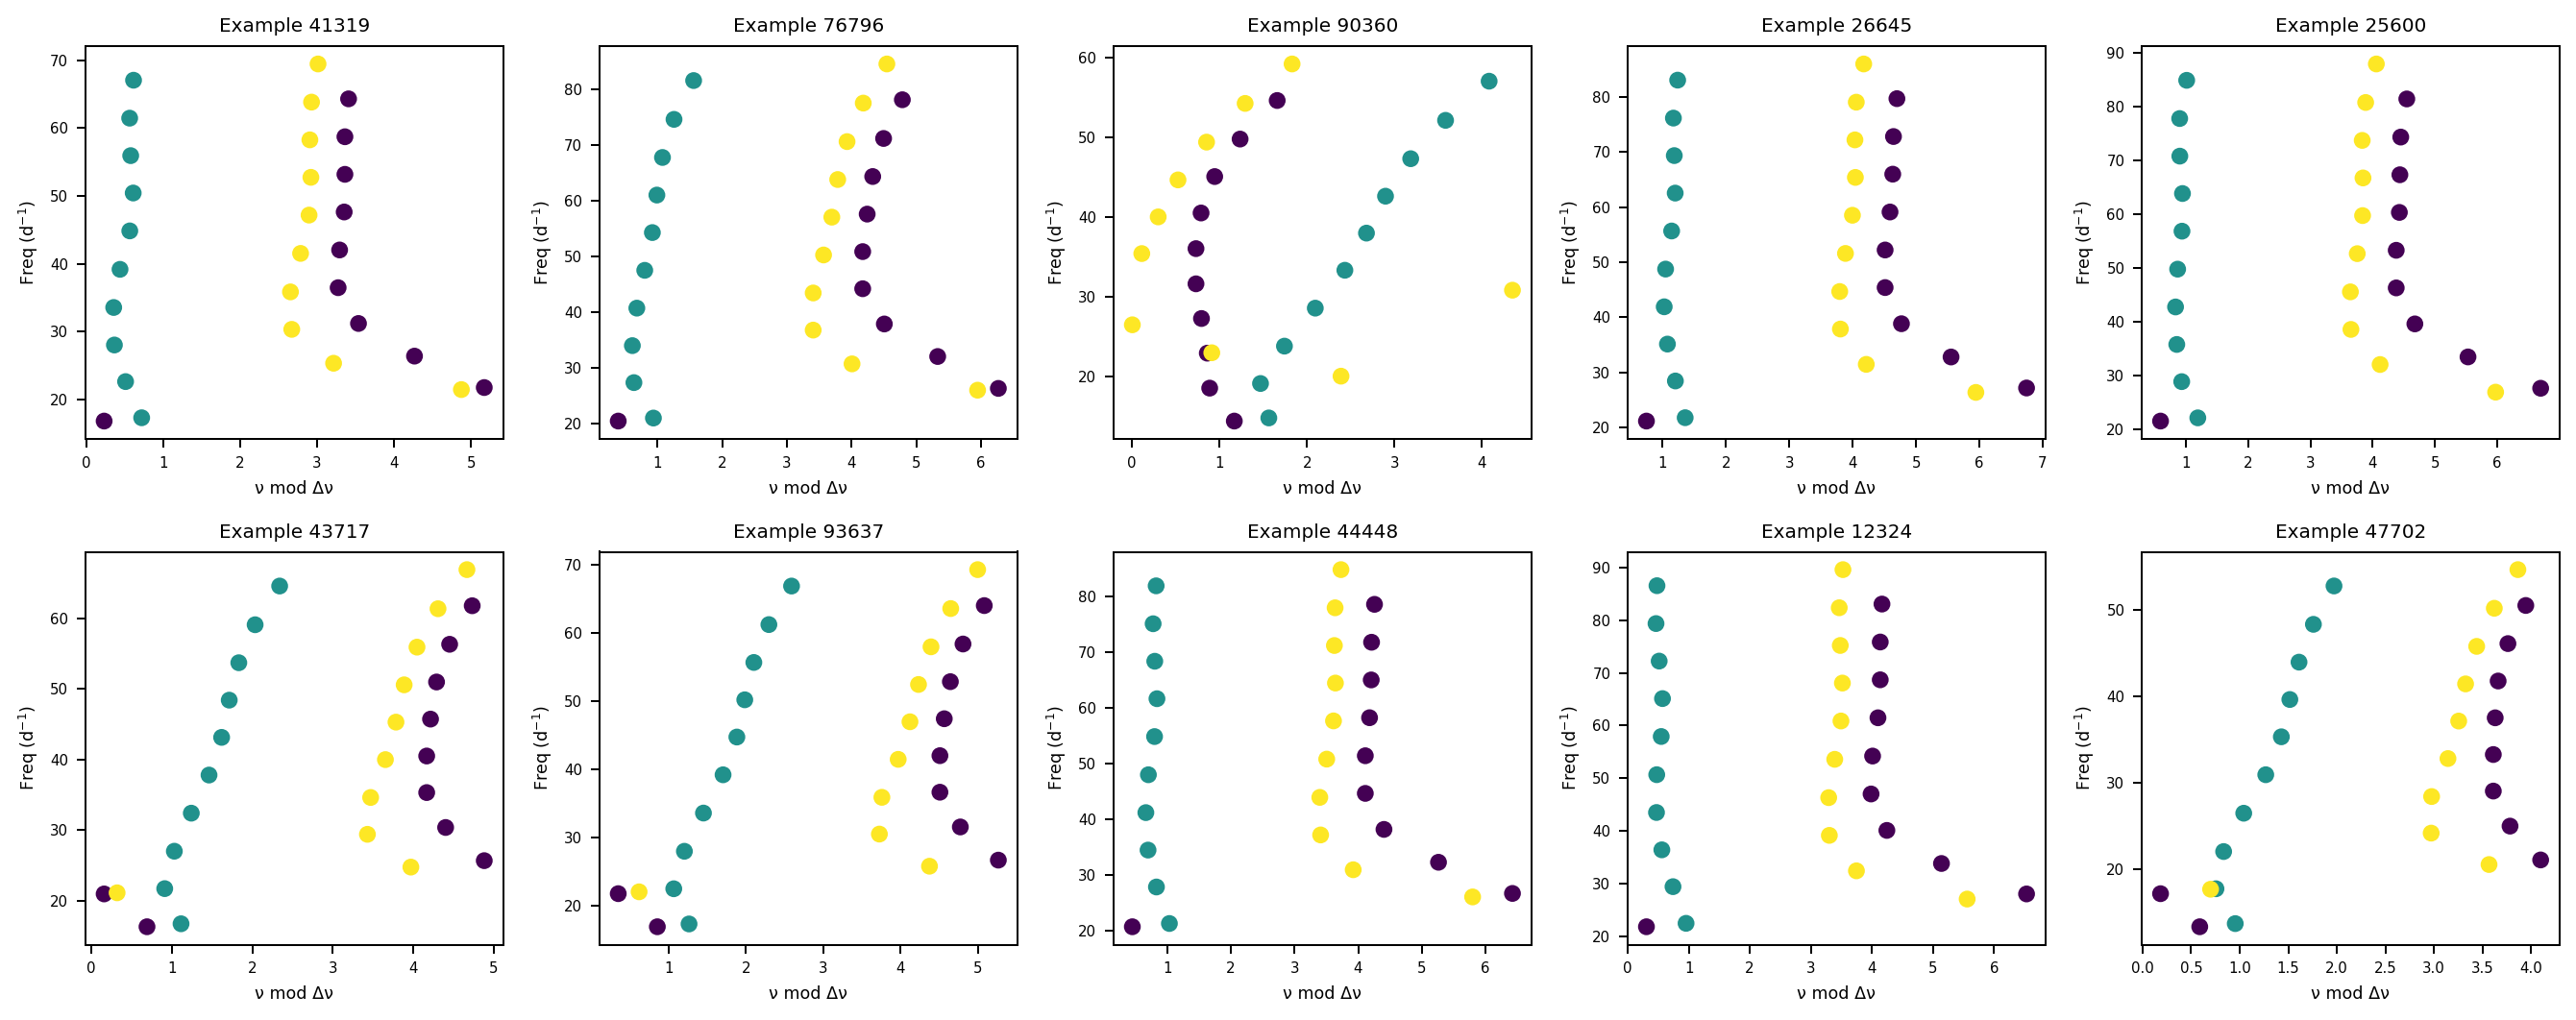

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# randomly sample 10 echelle diagrams
n_examples = 10
random_indices = np.random.choice(inpt.shape[0], n_examples, replace=False)

fig, axs = plt.subplots(2, 5, figsize=(15, 6), dpi=180)  # 5 columns, 2 rows
axs = axs.flatten()

for idx, ax in zip(random_indices, axs):
    freqs = inpt.detach().numpy()[idx, :, 1]
    powers = inpt.detach().numpy()[idx, :, 0]
    true_labels = y_train.detach().numpy()[idx]
    
    scatter = ax.scatter(freqs, powers, c=true_labels, cmap='viridis', vmin=0, vmax=2)
    ax.set_title(f"Example {idx}", fontsize=8)
    ax.set_xlabel("ν mod Δν", fontsize=7)
    ax.set_ylabel("Freq (d$^{-1}$)", fontsize=7)
    ax.tick_params(axis='both', which='major', labelsize=6)

# fig.colorbar(scatter, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
plt.tight_layout()
plt.savefig("echellepanel.jpg", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

## Analysis of the bad fits 

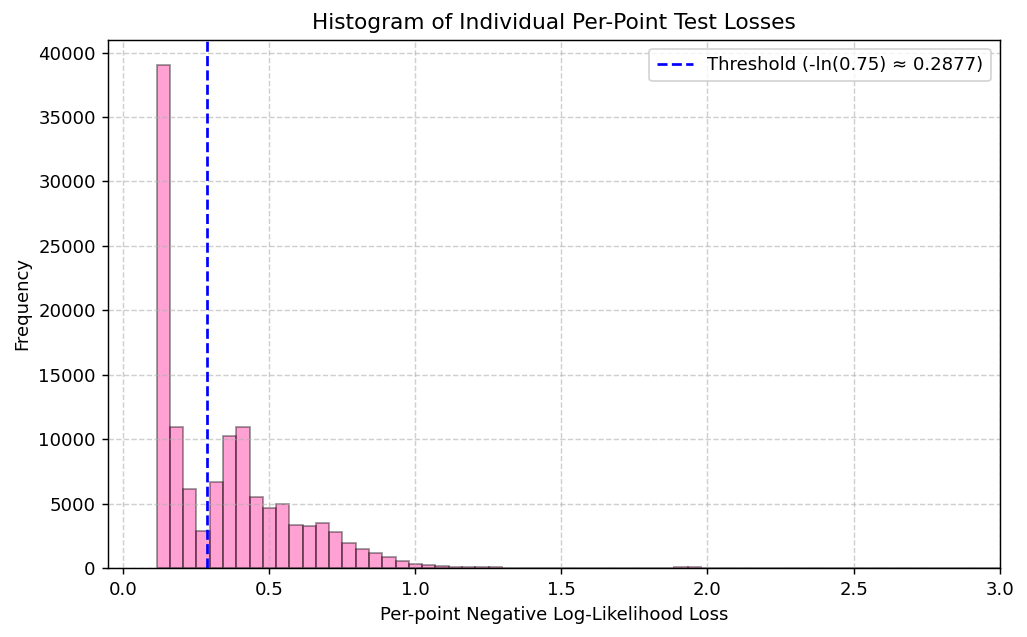

Bad fits above threshold: 1234350 / 3679530 (33.55%)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Load per-point test losses
with open("per_point_losses_test4.pkl", "rb") as f:
    per_point_losses = pickle.load(f)
per_point_losses = np.array(per_point_losses)

threshold = -np.log(0.75)

# Plot histogram
plt.figure(figsize=(8, 5), dpi=130)
plt.hist(average_loss_per_model, bins=100, color='deeppink', edgecolor='black', alpha=0.4)
plt.axvline(threshold, color='blue', linestyle='--', label=f'Threshold (-ln(0.75) ≈ {threshold:.4f})')
plt.xlim(-0.05, 3)
plt.xlabel("Per-point Negative Log-Likelihood Loss")
plt.ylabel("Frequency")
plt.title("Histogram of Individual Per-Point Test Losses")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("histogram_with_threshold.jpg", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

# Print some stats
bad_fit_count = np.sum(per_point_losses > threshold)
total_points = per_point_losses.size
print(f"Bad fits above threshold: {bad_fit_count} / {total_points} ({100 * bad_fit_count / total_points:.2f}%)")

In [8]:
print(f"Number of NaN losses: {np.isnan(per_point_losses).sum()}")

Number of NaN losses: 0


## Predictions for all l-values in one

Loss shape (aligned): (15332, 30)
X_test shape: torch.Size([15332, 30, 2])
Good Model Index: 11221, Good Point Index: 27
Bad Model Index: 6118, Bad Point Index: 6
Accessed Good Loss: 0.004605400841683149
Accessed Bad Loss: 0.4637044072151184


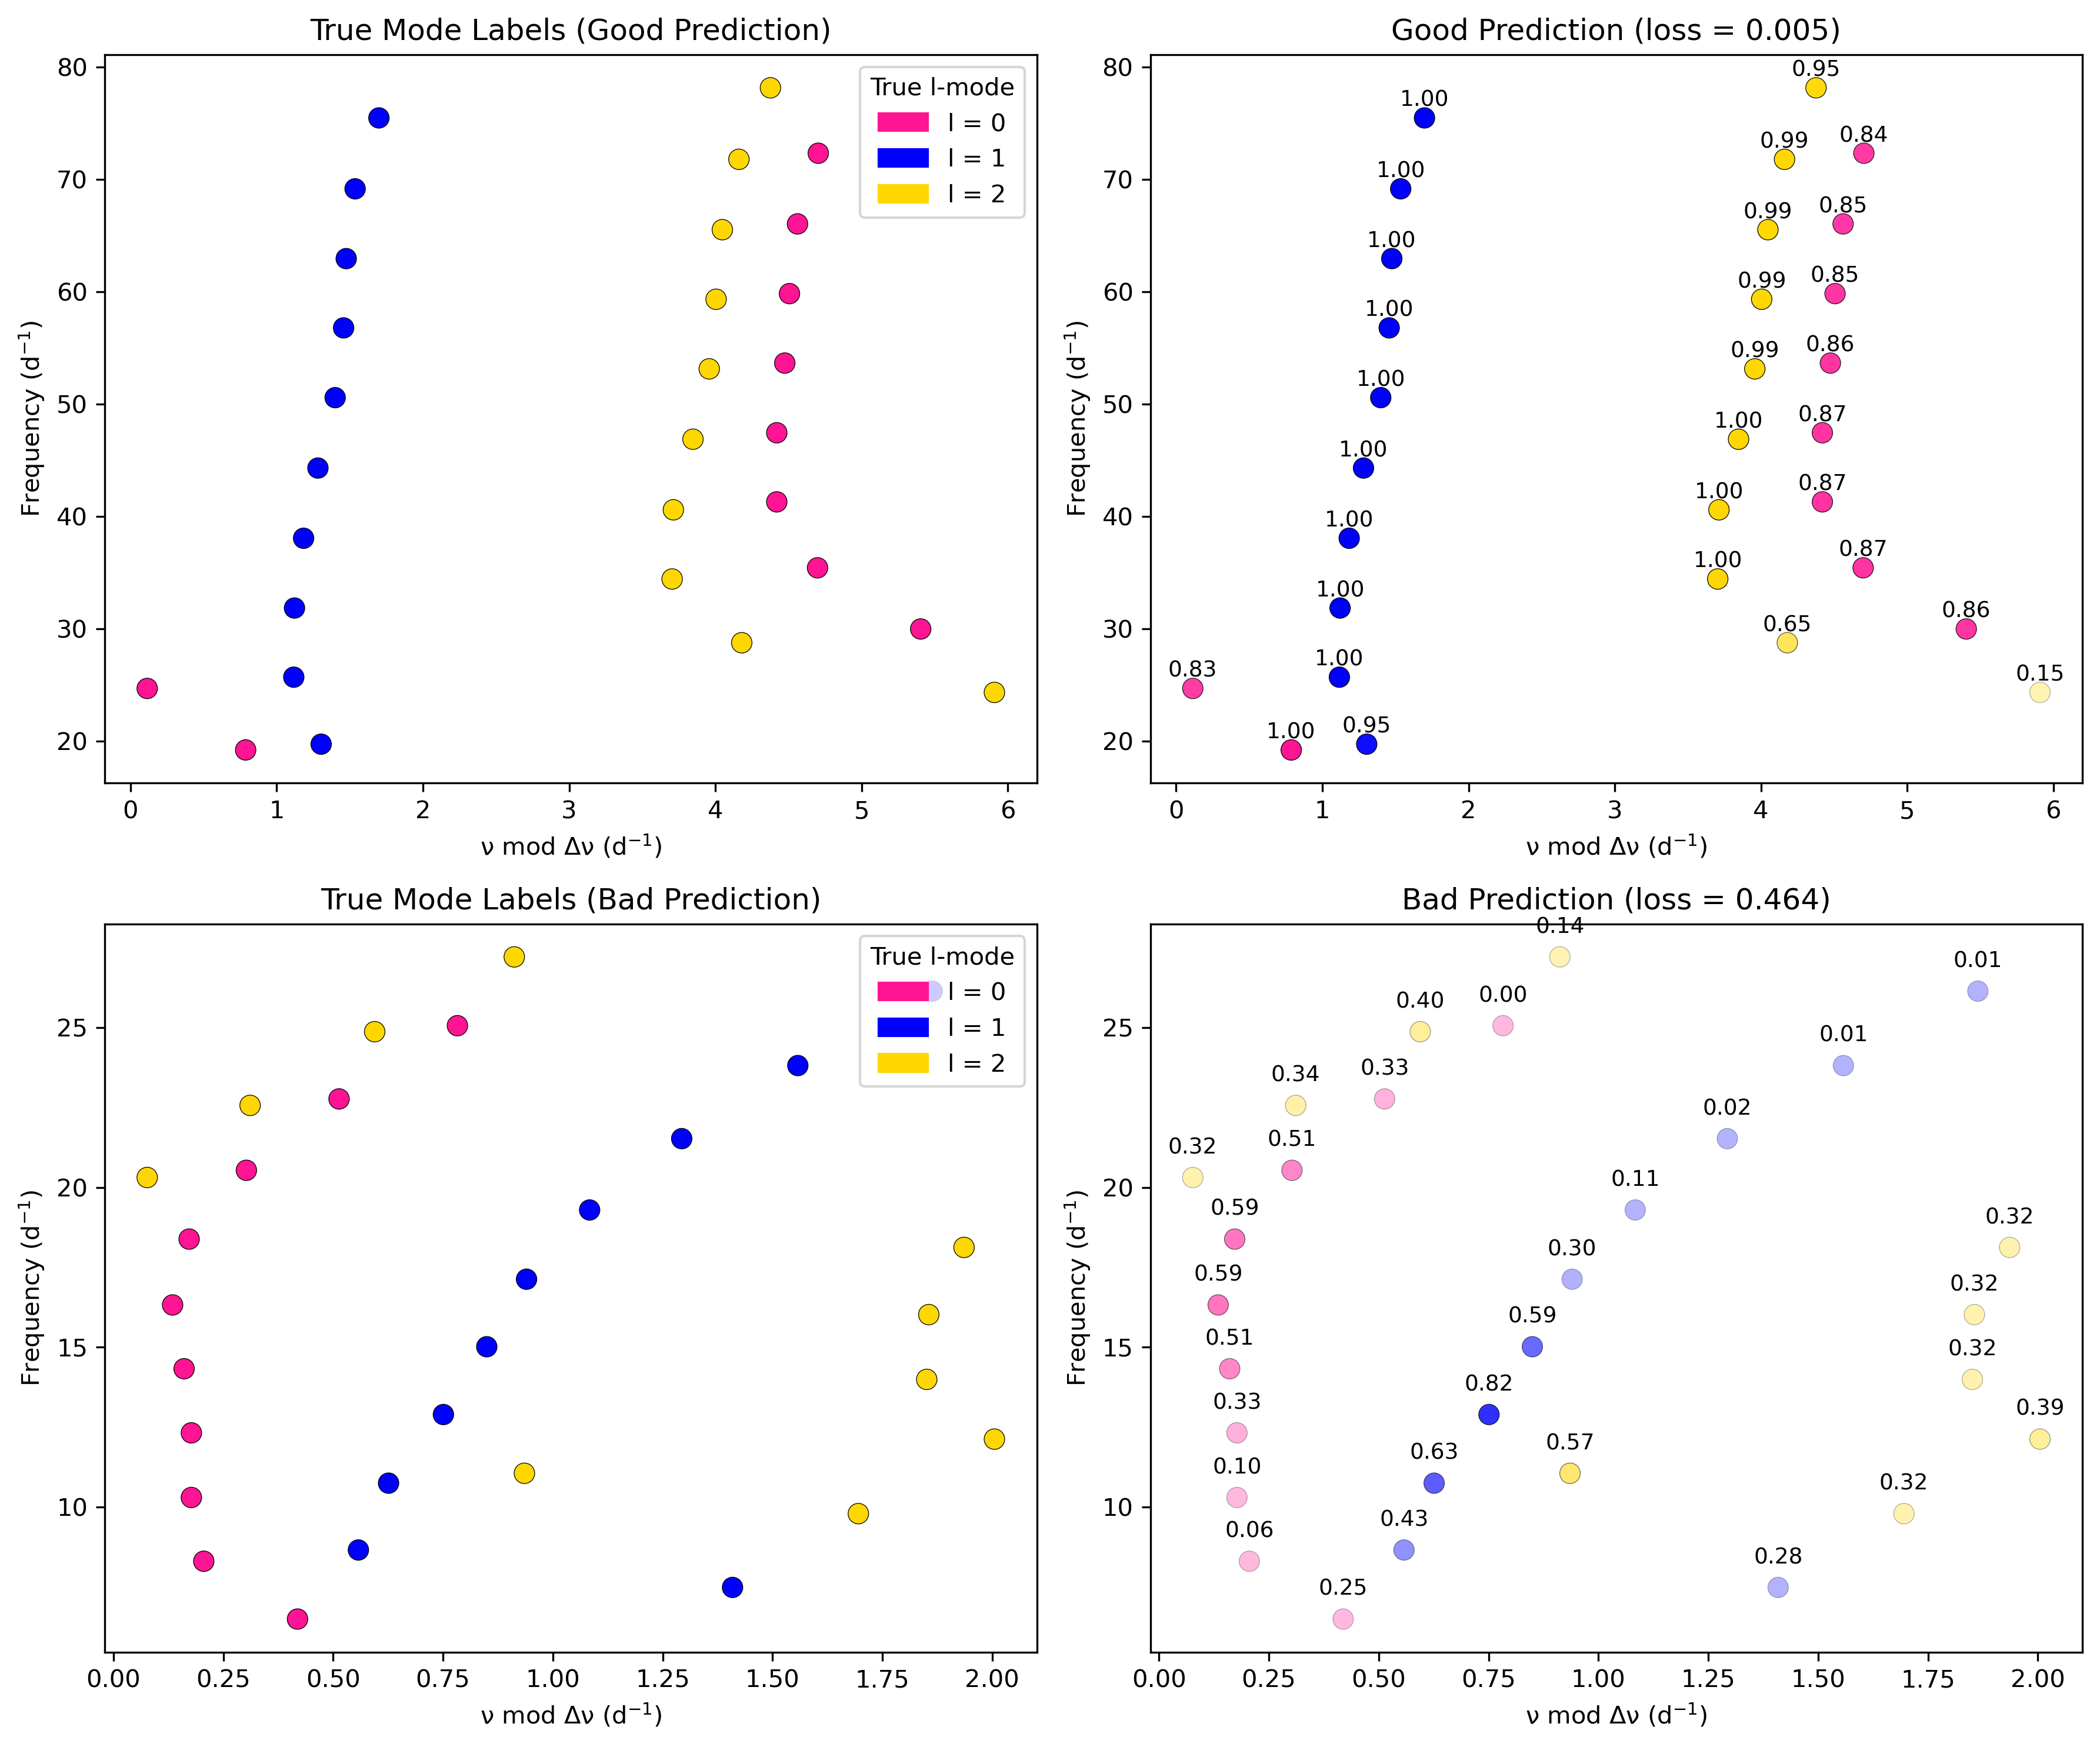

In [9]:
import matplotlib.patches as mpatches
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open("per_point_losses_test4.pkl", "rb") as f:
    per_point_losses = pickle.load(f)
per_point_losses = np.array(per_point_losses)

per_point_losses = per_point_losses[:X_test.shape[0], :]
print("Loss shape (aligned):", per_point_losses.shape)
print("X_test shape:", X_test.shape)

# Threshold based on loss histogram analysis
threshold = 0.2877
n_models, n_points = per_point_losses.shape

good_indices = np.argwhere(per_point_losses <= threshold)
bad_indices = np.argwhere(per_point_losses > threshold)

# now we select one good and one bad prediction randomly
good_model_idx, good_point_idx = good_indices[np.random.choice(len(good_indices))]
bad_model_idx, bad_point_idx = bad_indices[np.random.choice(len(bad_indices))]

print(f"Good Model Index: {good_model_idx}, Good Point Index: {good_point_idx}")
print(f"Bad Model Index: {bad_model_idx}, Bad Point Index: {bad_point_idx}")
print(f"Accessed Good Loss: {per_point_losses[good_model_idx, good_point_idx]}")
print(f"Accessed Bad Loss: {per_point_losses[bad_model_idx, bad_point_idx]}")

# function to get data for a given model index
def get_model_data(model_idx):
    freqs = X_test[model_idx, :, 1].detach().cpu().numpy()
    powers = X_test[model_idx, :, 0].detach().cpu().numpy()
    labels = y_test[model_idx, :].detach().cpu().numpy()
    
    logits = output[model_idx].detach().cpu().numpy()
    probs = np.exp(logits)
    probs /= probs.sum(axis=-1, keepdims=True)
    
    return freqs, powers, labels, probs

# Using the function we just defined
freqs_good, powers_good, labels_good, probs_good = get_model_data(good_model_idx)
freqs_bad, powers_bad, labels_bad, probs_bad = get_model_data(bad_model_idx)

color_map = {0: 'deeppink', 1: 'blue', 2: 'gold'}
colors_good = [color_map[int(l)] for l in labels_good]
colors_bad = [color_map[int(l)] for l in labels_bad]

legend_elements = [
    mpatches.Patch(color='deeppink', label='l = 0'),
    mpatches.Patch(color='blue', label='l = 1'),
    mpatches.Patch(color='gold', label='l = 2'),
]

marker_size = 70 

fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi=300)

# Plot 1: True Labels (Good)
axs[0, 0].scatter(freqs_good, powers_good, c=colors_good,
                  edgecolors='black', linewidths=0.3, s=marker_size)
axs[0, 0].legend(handles=legend_elements, title="True l-mode", loc="upper right")
axs[0, 0].set_title("True Mode Labels (Good Prediction)")
axs[0, 0].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[0, 0].set_ylabel("Frequency (d$^{-1}$)")

# Plot 2: Good Prediction 
conf_good = probs_good[np.arange(n_points), labels_good]
alpha_vals_good = np.clip(conf_good, 0.3, 1.0)
axs[0, 1].scatter(freqs_good, powers_good, c=colors_good, alpha=alpha_vals_good,
                  edgecolors='black', linewidths=0.3, s=marker_size)
for i in range(n_points):
    axs[0, 1].text(freqs_good[i], powers_good[i]+0.6, f"{probs_good[i, labels_good[i]]:.2f}",
                   fontsize=9, ha='center', va='bottom', color='black')
axs[0, 1].set_title(f"Good Prediction (loss = {per_point_losses[good_model_idx, good_point_idx]:.3f})")
axs[0, 1].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[0, 1].set_ylabel("Frequency (d$^{-1}$)")

# Plot 3: True Labels (Bad)
axs[1, 0].scatter(freqs_bad, powers_bad, c=colors_bad,
                  edgecolors='black', linewidths=0.3, s=marker_size)
axs[1, 0].legend(handles=legend_elements, title="True l-mode", loc="upper right")
axs[1, 0].set_title("True Mode Labels (Bad Prediction)")
axs[1, 0].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[1, 0].set_ylabel("Frequency (d$^{-1}$)")

# Plot 4: Bad Prediction 
conf_bad = probs_bad[np.arange(n_points), labels_bad]
alpha_vals_bad = np.clip(conf_bad, 0.3, 1.0)
axs[1, 1].scatter(freqs_bad, powers_bad, c=colors_bad, alpha=alpha_vals_bad,
                  edgecolors='black', linewidths=0.3, s=marker_size)
for i in range(n_points):
    axs[1, 1].text(freqs_bad[i], powers_bad[i]+0.6, f"{probs_bad[i, labels_bad[i]]:.2f}",
                   fontsize=9, ha='center', va='bottom', color='black')
axs[1, 1].set_title(f"Bad Prediction (loss = {per_point_losses[bad_model_idx, bad_point_idx]:.3f})")
axs[1, 1].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[1, 1].set_ylabel("Frequency (d$^{-1}$)")

plt.tight_layout()
plt.savefig("predictioncomparison.jpg", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

## Output comparison randomly selected good and bad prediction

Shape of per_point_losses: (122651, 30)
Accessed good loss: 0.39237165451049805
Accessed bad loss: 1.143456220626831


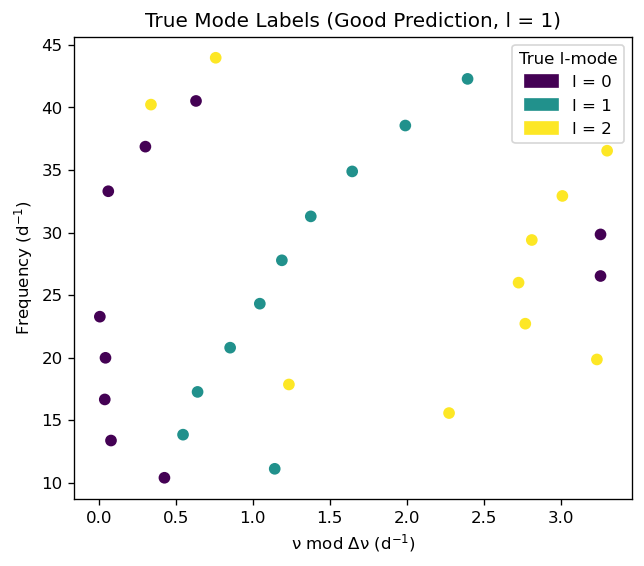

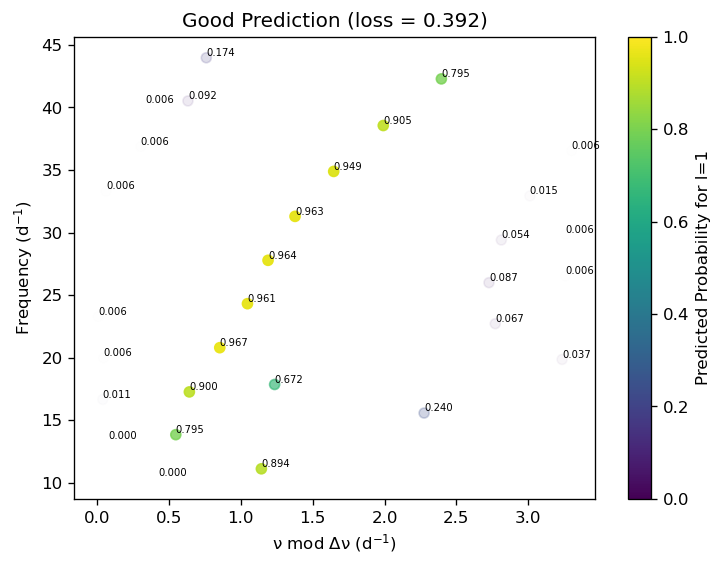

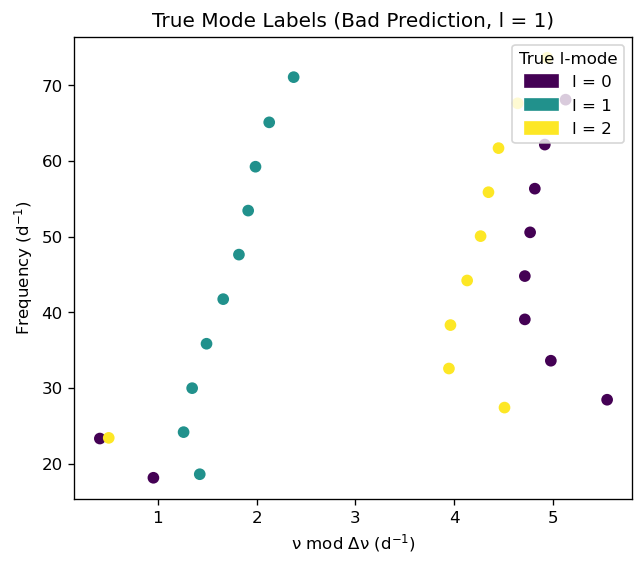

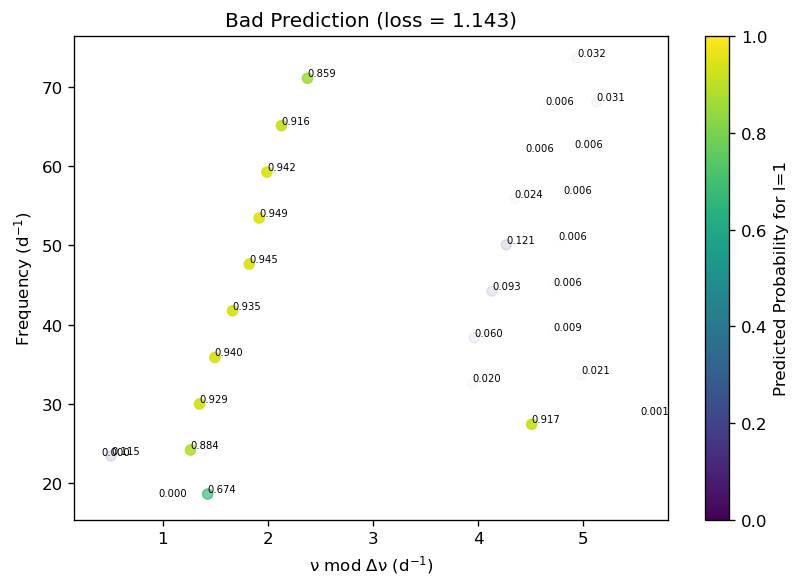

In [10]:
import matplotlib.patches as mpatches
import torch

with open("per_point_losses_test4.pkl", "rb") as f:
    per_point_losses = pickle.load(f)
per_point_losses = np.array(per_point_losses)

threshold = -np.log(0.75)
n_models = X_test.shape[0]
n_points = X_test.shape[1]
l = 1

bad_indices = np.where(per_point_losses > threshold)[0]
good_indices = np.where(per_point_losses <= threshold)[0]

# per_point_losses is a 2D array, so each entry has multiple points and we need to convert 2D->1D to select random points.
bad_idx_flat = np.random.choice(bad_indices)
good_idx_flat = np.random.choice(good_indices)

bad_model_idx, bad_point_idx = divmod(bad_idx_flat, n_points)
good_model_idx, good_point_idx = divmod(good_idx_flat, n_points)

# just some tiny sanity checks
print(f"Shape of per_point_losses: {per_point_losses.shape}")
#print(f"Good index flat: {good_idx_flat}")
#print(f"Bad index flat: {bad_idx_flat}")
print(f"Accessed good loss: {per_point_losses[good_model_idx, good_point_idx]}")
print(f"Accessed bad loss: {per_point_losses[bad_model_idx, bad_point_idx]}")

# in order to efficiently extract the data
def get_model_data(model_idx):
    freqs = X_test[model_idx, :, 1].detach().cpu().numpy()
    powers = X_test[model_idx, :, 0].detach().cpu().numpy()
    labels = y_test[model_idx, :].detach().cpu().numpy()
    
    logits = output[model_idx].detach().cpu().numpy() # extracts the actual outputs for the given index
    probs = np.exp(logits) # because the logits are still logits that need to me softmaxed to get probabilities
    probs /= probs.sum(axis=-1, keepdims=True)  # shape: (n_points, 3), to normalize exponential logits and obtain the actual probabilities
    
    return freqs, powers, labels, probs # all the stuff we need


# data for good and bad predictions
freqs_good, powers_good, labels_good, probs_good = get_model_data(good_model_idx)
freqs_bad, powers_bad, labels_bad, probs_bad = get_model_data(bad_model_idx)

# True label plot GOOD
freqs_control_good, powers_control_good, true_labels_good, _ = get_model_data(good_model_idx)

# True label plot BAD
freqs_control_bad, powers_control_bad, true_labels_bad, _ = get_model_data(bad_model_idx)


# True Labels GOOD
fig1, ax1 = plt.subplots(figsize=(6,5), dpi=120) 
ax1.scatter(freqs_control_good, powers_control_good, c=true_labels_good, cmap='viridis', vmin=0, vmax=2)
legend_elements = [
    mpatches.Patch(color=plt.cm.viridis(0.0), label=f'l = 0'),
    mpatches.Patch(color=plt.cm.viridis(0.5), label=f'l = 1'),
    mpatches.Patch(color=plt.cm.viridis(1.0), label=f'l = 2'),
]
ax1.legend(handles=legend_elements, title="True l-mode", loc="upper right")
ax1.set_title(f"True Mode Labels (Good Prediction, l = {l})")
ax1.set_xlabel("ν mod Δν (d$^{-1}$)")
ax1.set_ylabel("Frequency (d$^{-1}$)")

# Good Prediction
fig2, ax2 = plt.subplots(figsize=(7, 5), dpi=120) 
alpha_vals_good = np.clip(probs_good[:, l], 0, 1)  
scatter_good = ax2.scatter(freqs_good, powers_good, c=probs_good[:, l], cmap='viridis', vmin=0, vmax=1, alpha=alpha_vals_good)
ax2.set_title(f"Good Prediction (loss = {per_point_losses[good_model_idx, good_point_idx]:.3f})") 
ax2.set_xlabel("ν mod Δν (d$^{-1}$)")
ax2.set_ylabel("Frequency (d$^{-1}$)")
# Only annotate the selected l-mode probability next to the point
for i in range(n_points):
    ax2.text(freqs_good[i], powers_good[i], f"{probs_good[i, l]:.3f}", fontsize=6, ha='left', va='bottom', color='black')
# Add color bar for better understanding
fig2.colorbar(scatter_good, ax=ax2, label=f"Predicted Probability for l={l}")

# True Labels BAD (use different figure names to avoid overwriting)
fig3, ax3 = plt.subplots(figsize=(6, 5), dpi=120)  
ax3.scatter(freqs_control_bad, powers_control_bad, c=true_labels_bad, cmap='viridis', vmin=0, vmax=2)
legend_elements = [
    mpatches.Patch(color=plt.cm.viridis(0.0), label=f'l = 0'),
    mpatches.Patch(color=plt.cm.viridis(0.5), label=f'l = 1'),
    mpatches.Patch(color=plt.cm.viridis(1.0), label=f'l = 2'),
]
ax3.legend(handles=legend_elements, title="True l-mode", loc="upper right")
ax3.set_title(f"True Mode Labels (Bad Prediction, l = {l})")
ax3.set_xlabel("ν mod Δν (d$^{-1}$)")
ax3.set_ylabel("Frequency (d$^{-1}$)")

# Bad Prediction
fig4, ax4 = plt.subplots(figsize=(7, 5), dpi=120)  
alpha_vals_bad = np.clip(probs_bad[:, l], 0, 1)  
scatter_bad = ax4.scatter(freqs_bad, powers_bad, c=probs_bad[:, l], cmap='viridis', vmin=0, vmax=1, alpha=alpha_vals_bad)
ax4.set_title(f"Bad Prediction (loss = {per_point_losses[bad_model_idx, bad_point_idx]:.3f})")  # Access correct loss
ax4.set_xlabel("ν mod Δν (d$^{-1}$)")
ax4.set_ylabel("Frequency (d$^{-1}$)")
# Only annotate the selected l-mode probability next to the point
for i in range(n_points):
    ax4.text(freqs_bad[i], powers_bad[i], f"{probs_bad[i, l]:.3f}", fontsize=6, ha='left', va='bottom', color='black')
# Add color bar for better understanding
fig4.colorbar(scatter_bad, ax=ax4, label=f"Predicted Probability for l={l}")

# Show the plots
plt.tight_layout()
plt.show()

## PANEL VERSION: Output comparison of randomly selected good and bad predictions

(122651, 30)


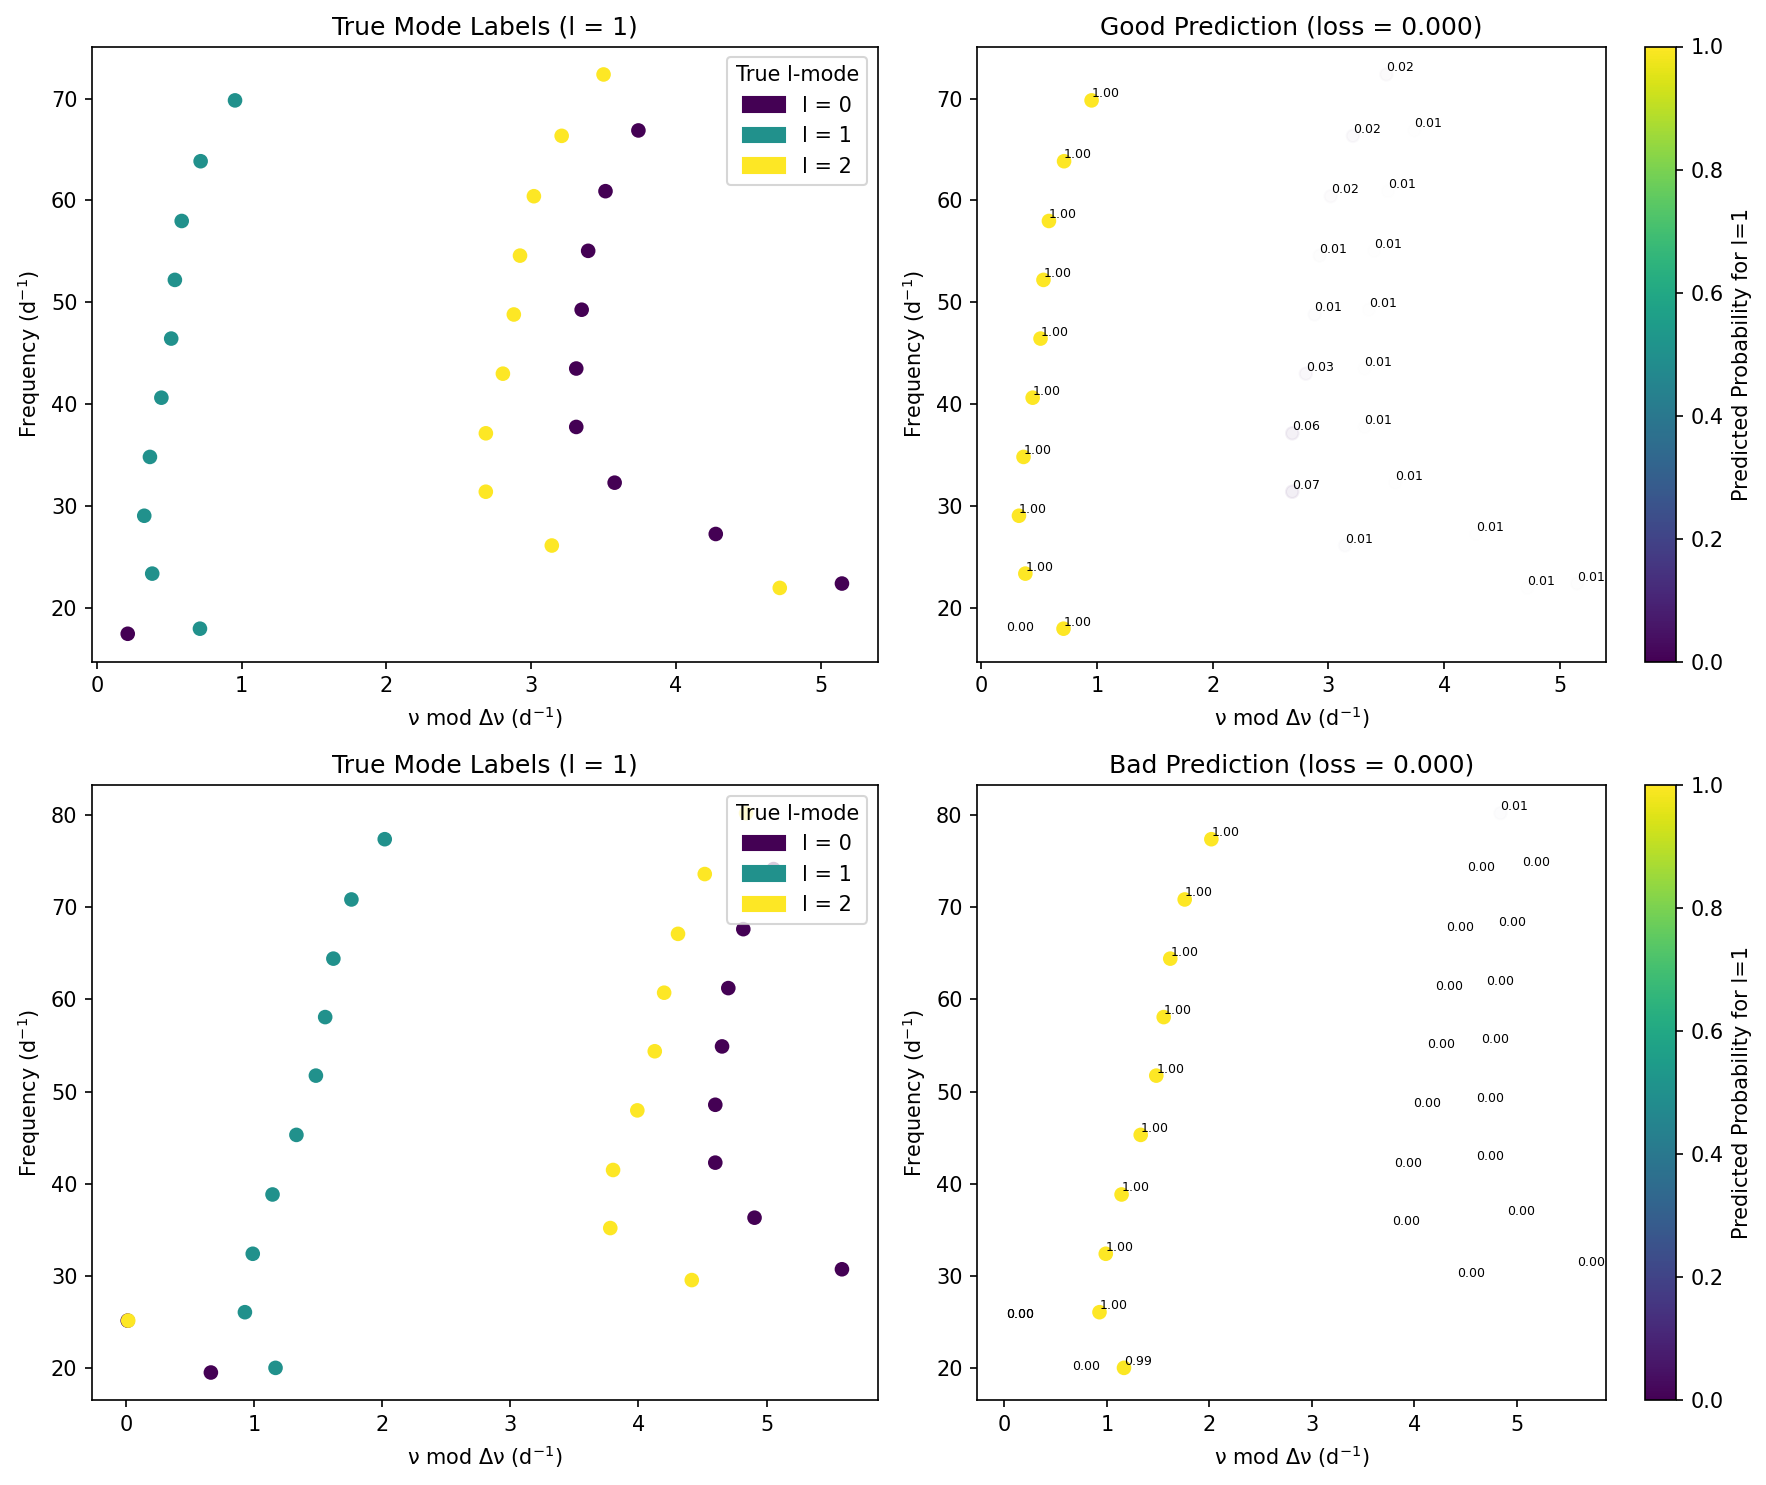

In [11]:
import matplotlib.patches as mpatches
import torch
import pickle

# Load data
with open("per_point_losses_test4.pkl", "rb") as f:
    per_point_losses = pickle.load(f)
per_point_losses = np.array(per_point_losses)
print(per_point_losses.shape)

threshold = -np.log(0.75)
n_models = X_test.shape[0]
n_points = X_test.shape[1]
l = 1

bad_indices = np.where(per_point_losses > threshold)[0]
good_indices = np.where(per_point_losses <= threshold)[0]

# per_point_losses is a 2D array, so each entry has multiple points and we need to convert 2D->1D to select random points.
bad_idx_flat = np.random.choice(bad_indices)
good_idx_flat = np.random.choice(good_indices)

bad_model_idx, bad_point_idx = divmod(bad_idx_flat, n_points)
good_model_idx, good_point_idx = divmod(good_idx_flat, n_points)

# In order to efficiently extract the data
def get_model_data(model_idx):
    freqs = X_test[model_idx, :, 1].detach().cpu().numpy()
    powers = X_test[model_idx, :, 0].detach().cpu().numpy()
    labels = y_test[model_idx, :].detach().cpu().numpy()
    
    logits = output[model_idx].detach().cpu().numpy()  # Extract the actual outputs for the given index
    probs = np.exp(logits)  # apply exponential to logits cause they need to be softmaxed
    probs /= probs.sum(axis=-1, keepdims=True)  # Normalize to get probabilities
    
    return freqs, powers, labels, probs  # Return the necessary data

# Data for good and bad predictions
freqs_good, powers_good, labels_good, probs_good = get_model_data(good_model_idx)
freqs_bad, powers_bad, labels_bad, probs_bad = get_model_data(bad_model_idx)

# True label plot GOOD
freqs_control_good, powers_control_good, true_labels_good, _ = get_model_data(good_model_idx)

# True label plot BAD
freqs_control_bad, powers_control_bad, true_labels_bad, _ = get_model_data(bad_model_idx)

fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi=150)

# Plot 1: True Labels GOOD
axs[0, 0].scatter(freqs_control_good, powers_control_good, c=true_labels_good, cmap='viridis', vmin=0, vmax=2)
legend_elements = [
    mpatches.Patch(color=plt.cm.viridis(0.0), label=f'l = 0'),
    mpatches.Patch(color=plt.cm.viridis(0.5), label=f'l = 1'),
    mpatches.Patch(color=plt.cm.viridis(1.0), label=f'l = 2'),
]
axs[0, 0].legend(handles=legend_elements, title="True l-mode", loc="upper right")
axs[0, 0].set_title(f"True Mode Labels (l = {l})")
axs[0, 0].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[0, 0].set_ylabel("Frequency (d$^{-1}$)")

# Plot 2: Good Prediction
alpha_vals_good = np.clip(probs_good[:, l], 0, 1)
scatter_good = axs[0, 1].scatter(freqs_good, powers_good, c=probs_good[:, l], cmap='viridis', vmin=0, vmax=1, alpha=alpha_vals_good)
axs[0, 1].set_title(f"Good Prediction (loss = {per_point_losses[good_model_idx, good_point_idx]:.3f})")
axs[0, 1].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[0, 1].set_ylabel("Frequency (d$^{-1}$)")
for i in range(n_points):
    axs[0, 1].text(freqs_good[i], powers_good[i], f"{probs_good[i, l]:.2f}", fontsize=6, ha='left', va='bottom', color='black')
fig.colorbar(scatter_good, ax=axs[0, 1], label=f"Predicted Probability for l={l}")

# Plot 3: True Labels BAD
axs[1, 0].scatter(freqs_control_bad, powers_control_bad, c=true_labels_bad, cmap='viridis', vmin=0, vmax=2)
axs[1, 0].legend(handles=legend_elements, title="True l-mode", loc="upper right")
axs[1, 0].set_title(f"True Mode Labels (l = {l})")
axs[1, 0].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[1, 0].set_ylabel("Frequency (d$^{-1}$)")

# Plot 4: Bad Prediction
alpha_vals_bad = np.clip(probs_bad[:, l], 0, 1)
scatter_bad = axs[1, 1].scatter(freqs_bad, powers_bad, c=probs_bad[:, l], cmap='viridis', vmin=0, vmax=1, alpha=alpha_vals_bad)
axs[1, 1].set_title(f"Bad Prediction (loss = {per_point_losses[bad_model_idx, bad_point_idx]:.3f})")
axs[1, 1].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[1, 1].set_ylabel("Frequency (d$^{-1}$)")
for i in range(n_points):
    axs[1, 1].text(freqs_bad[i], powers_bad[i], f"{probs_bad[i, l]:.2f}", fontsize=6, ha='left', va='bottom', color='black')
fig.colorbar(scatter_bad, ax=axs[1, 1], label=f"Predicted Probability for l={l}")

plt.tight_layout()
plt.show()

(122651,)
(122651,)
Bad models: 2177
Good models: 13155
Total models: 15332


/home/tatjanagobold/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tatjanagobold/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


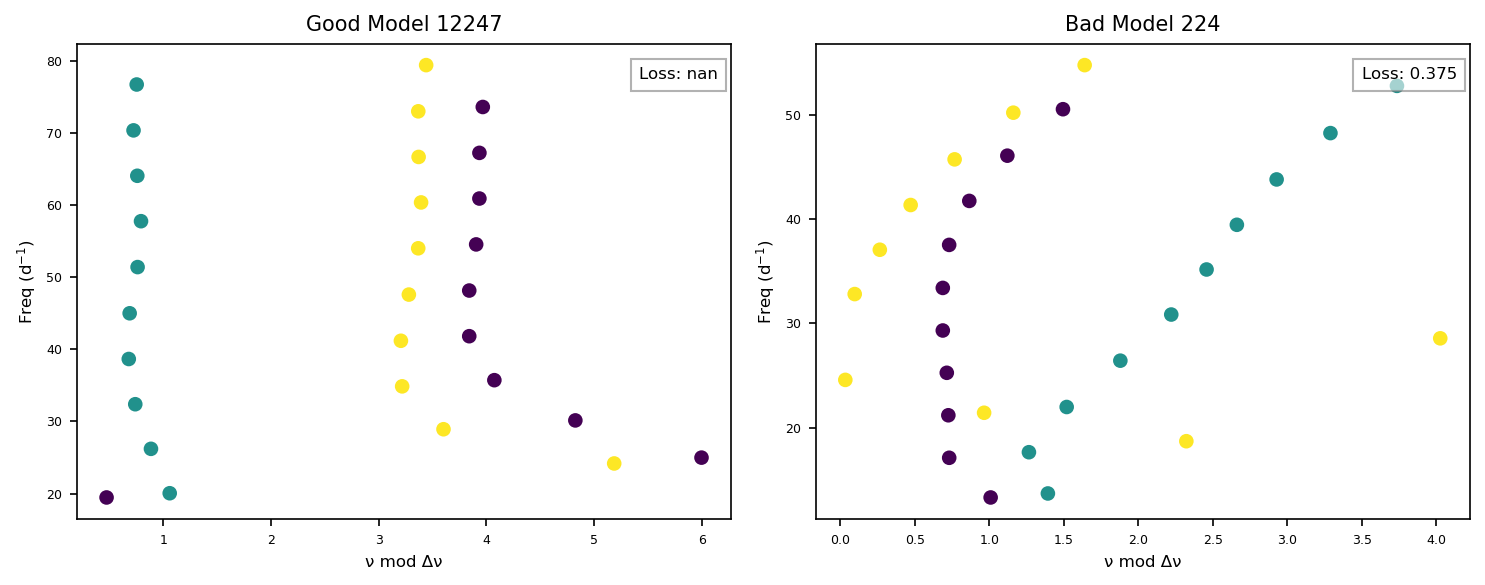

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle

# Load saved losses and test data
with open("average_loss_per_model4.pkl", "rb") as f:
    per_point_losses = pickle.load(f)
    
per_point_losses = np.array(per_point_losses)
print(per_point_losses.shape)

# Constants
n_points = 30
n_test_models = X_test.shape[0]  
n_test_points = n_points * n_test_models

# Get losses for X_test models only (last portion of full per_point_losses array)
test_per_point_losses = per_point_losses[-n_test_points:]

print(test_per_point_losses.shape)
# Identify good/bad models
bad_model_indices = []
good_model_indices = []

for i in range(n_test_models):
    losses_i = test_per_point_losses[i * n_points : (i + 1) * n_points]
    bad_fraction = np.sum(losses_i > threshold) / n_points
    if bad_fraction > 0.5:
        bad_model_indices.append(i)
    else:
        good_model_indices.append(i)

print(f"Bad models: {len(bad_model_indices)}")
print(f"Good models: {len(good_model_indices)}")
print(f"Total models: {len(bad_model_indices) + len(good_model_indices)}")

# Randomly pick one good and one bad model
bad_idx = np.random.choice(bad_model_indices, 1)[0]
good_idx = np.random.choice(good_model_indices, 1)[0]

# Plotting function
def plot_echelle(idx, ax, title, loss):
    freqs = X_test[idx, :, 1].detach().cpu().numpy()  # ν mod Δν
    powers = X_test[idx, :, 0].detach().cpu().numpy()  # frequency
    labels = y_test[idx, :].detach().cpu().numpy()
    
    ax.scatter(freqs, powers, c=labels, cmap='viridis', vmin=0, vmax=2)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("ν mod Δν", fontsize=8)
    ax.set_ylabel("Freq (d$^{-1}$)", fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.text(0.98, 0.95, f"Loss: {loss:.3f}", transform=ax.transAxes,
            fontsize=8, ha='right', va='top',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray'))

# Calculate losses for the good and bad models
good_model_loss = np.mean(test_per_point_losses[good_idx * n_points : (good_idx + 1) * n_points])
bad_model_loss = np.mean(test_per_point_losses[bad_idx * n_points : (bad_idx + 1) * n_points])

# Create subplots for good and bad models
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)

# Plot the selected good and bad models
plot_echelle(good_idx, axs[0], f"Good Model {good_idx}", good_model_loss)
plot_echelle(bad_idx, axs[1], f"Bad Model {bad_idx}", bad_model_loss)

plt.tight_layout()
# plt.savefig("good_bad_model_echelle.jpg", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()
